### Time series analysis

This notebook fits time-series analysis models to NYC attendance data to predict future absence rates.

In [1]:
import glob # TODO: Check whether this is still used, if not, delete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pmdarima as pm
import os # TODO: Check whether this is still used, if not, delete
import seaborn as sns
import skforecast


from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.recursive import ForecasterRecursive
# TODO: Check which of the following get used once notebook is finalized,
# gid rid of rest
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster, TimeSeriesFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA

#### Reading in, examining, and preparing the attendance data

I took a random sample of 15 schools, but the original open source data from NYC had thousands of schools! We will be working with just one school here, but feel free to try out these models later on your own with other schools.

In [2]:
# Saving url for Git repository
git_url = 'https://github.com/tarachiatovich/zero_to_ai_sdp_2025/'
# Reading in data from Git
# Datasource (open, publicly available):
# https://opendata.cityofnewyork.us/

# TODO: Will need to update once branch is merged
git_nyc_path = git_url +\
    'blob/improve_tabular_notebooks/clean_data/attendance/full_attendance_data.csv?raw=true'

In [3]:
attendance_data = pd.read_csv(git_nyc_path)

In [4]:
# Look at the columns
attendance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26766 entries, 0 to 26765
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   School      26766 non-null  object 
 1   Date        26766 non-null  object 
 2   SchoolYear  26766 non-null  int64  
 3   Enrolled    26762 non-null  float64
 4   Absent      26762 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
# Skipping to save time, but you can uncomment
# to get a frequency table for School values
# attendance_data['School'].value_counts()

In [6]:
# We need the Date column to be an official
# datetime object
attendance_data['Date'] = pd.to_datetime(
    attendance_data['Date'],
    dayfirst=False, format='mixed'
)

In [7]:
# We're going to work with just one school for now,
# though you can do the same analysis choosing another
# school later on
school_id_to_use = '01M015'

In [8]:
# Creating a dataframe limited to one school
data_1_school = attendance_data.loc[attendance_data['School'] == school_id_to_use].sort_values('Date')

In [9]:
# Skipping for time, but you can uncomment
# This checks that each date appears only
# once in the data
# data_1_school.Date.value_counts()

<Axes: xlabel='Date', ylabel='Count'>

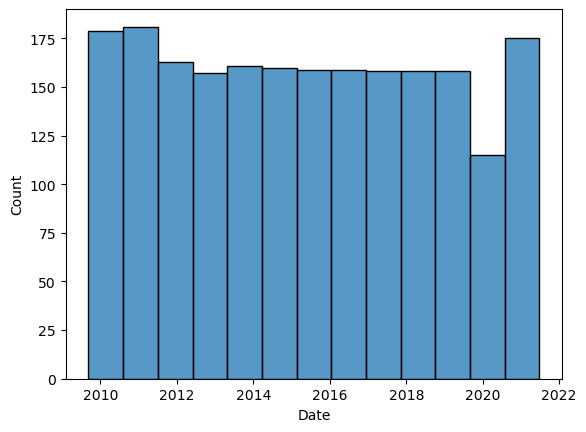

In [10]:
# Look at histogram giving dates for first school
# These bars look nice and even, except for circa
# 2020, which is no surprise given the pandemic
sns.histplot(data=data_1_school, x='Date')

In [11]:
# Create an absence rate that adjusts for enrollment
data_1_school['AbsenceRate'] = data_1_school['Absent']/data_1_school['Enrolled']

In [12]:
# Let's get descriptives on AbsenceRate
data_1_school[['AbsenceRate', 'Absent']].describe()

,AbsenceRate,Absent
count,2083.000000,2083.000000
mean,0.081130,15.245319
std,0.054027,10.506703
min,0.000000,0.000000
25%,0.047120,9.000000
50%,0.068421,13.000000
75%,0.097826,18.500000
max,0.618090,123.000000


In [13]:
# Skipping for time -- you can uncomment if desired
# Look at first few rows of data with AbsenceRate
# data_1_school.head()

#### Creating training, validition, and testing data

We will fit our model on training data, adjust it based on how it performs on validition data, and then do a final check of how it does on "hold out" or "out of bag" testing data.

In [14]:
# Let's get the data ready for analyses by splitting
# Date into training, validiation, and testing sets
tscv = TimeSeriesSplit(n_splits=2, test_size=180)
data_1_school_for_ts = data_1_school.copy()

In [15]:
# Getting together the "split" data
# TimeSeriesSplit splits the data twice, into two folds.
# We can use data from the first fold to get our model up and running
# and then once we are happy with our model for that dataframe, do a final check
# of how it runs on the dataframe from the second fold.
train_test_indices = {}
for i, (train_index, test_index) in enumerate(tscv.split(data_1_school_for_ts['Date'])):
    train_test_indices[f"train_fold_{i}"] = train_index
    train_test_indices[f"test_fold_{i}"] = test_index

In [17]:
# This part is very "Python-y" and may be confusing for people who are new to Python
# It just uses indices to get the right parts of the data for training, validition,
# and "hold out"/"out of bag" testing

# Use the indices [0] and [-1] to get the first part and last Date for the training
# data
train_start = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][0]]['Date']
train_end = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][-1]]['Date']

# Do the same as above, but this time for our validation data
val_start = data_1_school_for_ts.iloc[train_test_indices['test_fold_0'][0]]['Date']
val_end = data_1_school_for_ts.iloc[train_test_indices['test_fold_0'][-1]]['Date']

# Let's also get our "hold out"/"out of bag" data now so we'll be ready to see how
# the model performs with unseen data
hold_out_test_start = data_1_school_for_ts.iloc[train_test_indices['test_fold_1'][0]]['Date']
hold_out_test_end = data_1_school_for_ts.iloc[train_test_indices['test_fold_1'][-1]]['Date']

In [18]:
# Let's check on the start and end dates for taining and
# validition data
print(train_start)
print(train_end)
print(val_start)
print(val_end)

2009-09-09 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2020-03-06 00:00:00


In [19]:
# And we'll also look at the start and end
# dates for our hold out data
# Note that these dates including the start of the pandemic!
print(hold_out_test_start)
print(hold_out_test_end)

2020-03-09 00:00:00
2021-06-25 00:00:00


In [20]:
# Setting the Date column as our index
data_1_school_for_ts.set_index('Date', inplace = True)

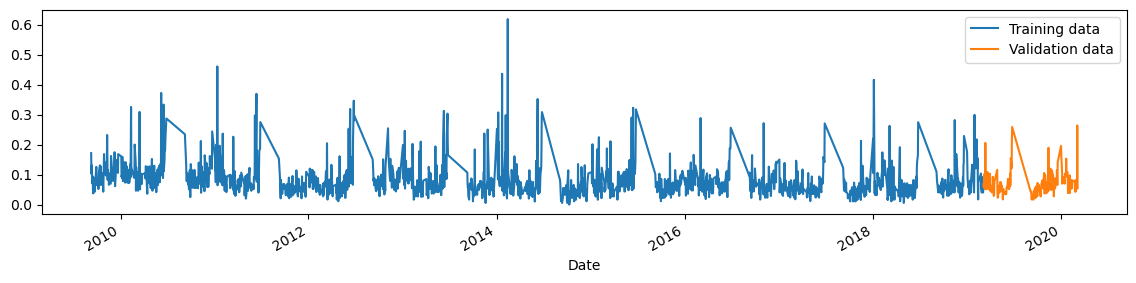

In [21]:
# Let's look at our measure of attendance, absence rate
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end].plot(ax=ax, label = "Training data")
data_1_school_for_ts['AbsenceRate'].loc[val_start: val_end].plot(ax=ax, label = "Validation data")
ax.legend()

#### Running the time series models

Let's run the models! We run three, but I only show output for two to keep things simple.

In [39]:
# Source consulted when writing the code:
# https://medium.com/@mouse3mic3/a-practical-guide-on-scikit-learn-for-time-series-forecasting-bbd15b611a5d

# TODO: Properly supress this warning
# Supressing a warning message (not important)
# warnings.simplefilter('ignore', category=IndexWarning)

# Set the values for the index for the predictions, based
# on start and end dates for validation data
dates_for_preds = data_1_school_for_ts.loc[val_start: val_end].index.values
# Doing the same for the hold out testing data
dates_for_hold_out = data_1_school_for_ts.loc[hold_out_test_start: hold_out_test_end].index.values
# Define the forecaster
forecaster_tree=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=DecisionTreeRegressor(random_state=123),
    lags=20
)
# Define the forecaster
forecaster_lgbmr=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=LGBMRegressor(random_state=123, verbose=-1),
    lags=20
)

# Store the model algorithms in a list for looping
model_algs = [forecaster_tree, forecaster_lgbmr]
# Store a name for each model algorithm, also for looping
model_names = ['tree', 'lgbmr']
# Create an empty map for storing the data, the root mean square error
reg_model_preds = {}
reg_model_rmses = {}
# Fit the models using train data
for model_alg, model_name in zip(model_algs, model_names):
    model_alg.fit(y = data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

    # Predict the test period
    predicted_test = model_alg.predict(
        steps = len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end])
    )
    predicted_test = pd.DataFrame(predicted_test)
    predicted_test['Date'] = dates_for_preds
    predicted_test.set_index('Date', inplace = True)

    # Get RMSE
    rmse_test = np.sqrt(mean_squared_error(
        data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end],
        predicted_test)
    )
    # This prints the RMSE, commenting out to keep output simple
    # print(f'RMSE for {model_name}')
    # print('RMSE Test:', rmse_test)

    # Store results in reg_model_results, with model specified
    reg_model_preds[model_name] = predicted_test
    reg_model_rmses[model_name] = rmse_test

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [26]:
# TODO: Fix warnings!
# TODO: Incorporate into loop?
# Running one more model, auto-ARIMA
arima = pm.AutoARIMA(seasonal = True)
arima.fit(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end]))
arima_test = pd.DataFrame(arima_test, columns=['pred'])
arima_test = arima_test.set_index(dates_for_preds)

# Gettung the RMSE
arima_rmse_train = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end], arima_train))
arima_rmse_test = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end], arima_test))
print('ARIMA RMSE Train:', round(arima_rmse_train, 4),'\nARIMA RMSE Test:', round(arima_rmse_test, 4))

C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

ARIMA RMSE Train: 0.05 
ARIMA RMSE Test: 0.04


C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


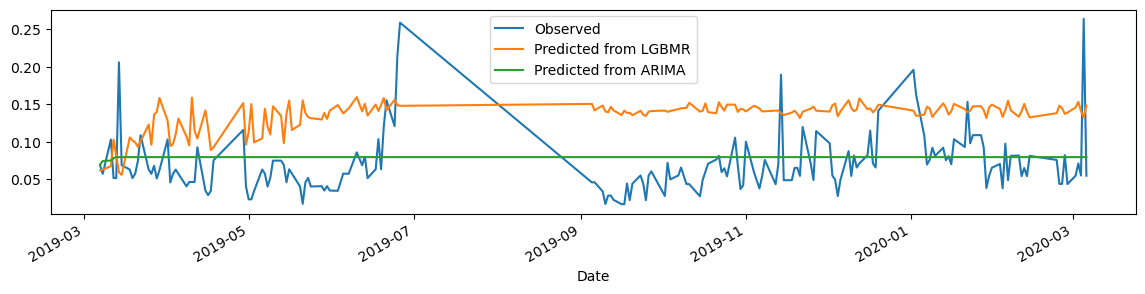

In [28]:
# Here are our predictions
# To keep things simple, the predictions for the DecisionTreeRegressor
# are commented out, but you can see how they look on your own by uncommenting
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
# reg_model_preds['tree']['pred'].plot(ax=ax, label="Predicted from tree")
ax.legend()

#### Hyperparameter tuning

Let's see if hyperparameter tuning improves our Light gradient boosting machine regressor. We are not hyperparameter tuning auto-ARIMA because auto-ARIMA actually fits more than one model and then chooses the best one (though note there are still different things one can do to try to improve it).

Note that we use GridSearchCV, which tests out all combinations. If you end up doing more with machine learning, I recommend looking up Optuna, which strategically chooses which combinations of hyperparameters to focus on for faster (and generally better) hyperparameter tuning. 

For future reference, you can read more about how auto-ARIMA chooses the best model here:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [32]:
# Hyperparameter tuning for most promising model: light gradient boosting machine regressor
# Code inspired by this source:
# https://skforecast.org/0.15.0/user_guides/hyperparameter-tuning-and-lags-selection.html
# Also see this source:
# https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

# If you have extra time, you could play around with changing
# the parts with comments and see if you can do even better!
# Lags used as predictors
lags_grid = {
    'lags_1': 3, # Could try a different number here
    'lags_2': 10, # Or here
    'lags_3': [1, 2, 3, 20] # Or different and/or additional numbers here
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100], # Could try different and/or additional numbers here
    'max_depth': [5, 10, 15] # And here
}

# Setting up the cross-validation
# You can read more on your own here:
# https://www.coursera.org/articles/what-is-cross-validation-in-machine-learning
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end]),
         refit              = False
     )

# Running the hyperparameter tuning
results = grid_search_forecaster(
              forecaster    = forecaster_lgbmr,
              y             = data_1_school_for_ts['AbsenceRate'].loc[train_start:val_end].reset_index(drop=True),
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error', # What we are trying to minimize
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
# Showing the parameters, mean_squared_error for the 3 best models
pd.DataFrame(results).head(3)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.0017689823317217275


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 50}",0.001769,5,50
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 50}",0.001827,5,50
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 50}",0.001837,15,50
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 100}",0.001911,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 100}",0.001922,15,100


In [33]:
# Get predictions from tuned LGBMR forecaster
# We can do this because above we had return_best = True
# That means that grid_search_forecaster updated our forecaster_lgbmr model
# to have the tuned (best) hyperparameters
# So when we run `forecaster_lgbmr.predict` below, we are getting predictions
# using the tuned LGBMR model
predicted_val_tuned_lgbmr = forecaster_lgbmr.predict(steps = len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end]))
predicted_val_tuned_lgbmr = pd.DataFrame(predicted_val_tuned_lgbmr)
predicted_val_tuned_lgbmr['Date'] = dates_for_preds
predicted_val_tuned_lgbmr.set_index('Date', inplace = True)

# Get RMSE from tuned LGBMR forecaster
rmse_tuned_lgbmr = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end], predicted_val_tuned_lgbmr['pred']))

# Print RMSE, original and tuned
print(f"Light GRM regressor best root mean square error:  {round(rmse_tuned_lgbmr, 4)}")
print(f"Light GRM regressor untuned (original) root mean square error:  {round(reg_model_rmses['lgbmr'], 4)}")

Light GRM regressor best root mean square error:  0.064
Light GRM regressor untuned (original) root mean square error:  0.079


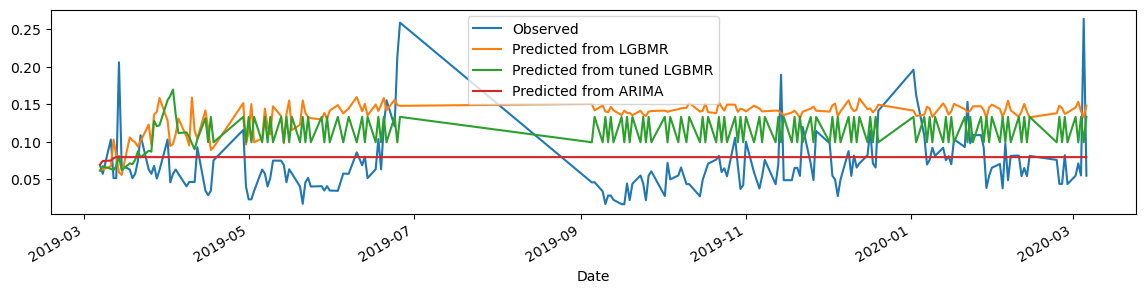

In [34]:
# Add data viz like the above but for "most likely" algorithms
# Point is (at least in part) to show that backfitting and hyperparameter tuning helped
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
predicted_val_tuned_lgbmr['pred'].plot(ax=ax, label="Predicted from tuned LGBMR")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

#### Discuss the results from the hyperparameter tuning

The green line above shows the predicted values from the tuned LGBMR model.

- What was the effect of the hyperparameter tuning?
- What are your thoughts on the predictions from the tuned model?
- The predictions from our auto-ARIMA model don't follow the peaks and valleys nearly as well, but do you think that model is doing better overall? What is the basis for your answer?

#### The final step!

Once you have done all you plan to do to improve your predictions with your model, you can see how it runs on the "hold out"  or "out of bag" data, the data we've never looked at before. This gives us a better sense of how we expect the model to perform in real time with data it has never "seen" before.

This will be...interesting...because the out of bag data include the beginning of the pandemic!

In [45]:
# Getting final predictions and final metrics
# Since we are having grid_search_forecaster return
# the best model, the line below should give predictions
# from your best model from your most recent running
# of grid_search_predictor
predicted_hold_out_lgbmr = forecaster_lgbmr.predict(
    steps = len(data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end])
)
predicted_hold_out_lgbmr = pd.DataFrame(predicted_hold_out_lgbmr)
predicted_hold_out_lgbmr['Date'] = dates_for_hold_out
predicted_hold_out_lgbmr.set_index('Date', inplace = True)

# Getting the RMSE, though maybe you want to gauge the
# model's performance from a different metric. Up to you!
rmse_hold_out_lgbmr = np.sqrt(
    mean_squared_error(
        data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end],
        predicted_hold_out_lgbmr['pred']
    ))
print("LGBMR RMSE for testing data: ", round(rmse_hold_out_lgbmr, 4))

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

LGBMR RMSE for testing data:  0.0602


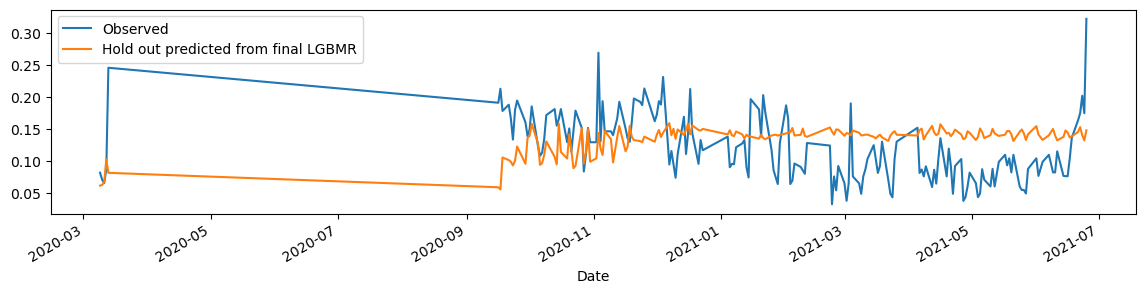

In [41]:
# How does the final model look with the hold out data?
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end].plot(ax=ax, label = "Observed")
# TODO: This is giving the wrong dates, fix
predicted_hold_out_lgbmr['pred'].plot(ax=ax, label="Hold out predicted from final LGBMR")
ax.legend()

How did we do? If you have time, briefly share out your reflections on the final predictions using the testing data with your group plus any other overall reflections you may have.

#### Additional things you can try on your own

1. Run the models on data from a different school by changing the school ID value saved in `school_id_to_use`.
2. Try choosing a different metric for seeing how your model performs and for the hyperparameter tuning. There is some commented out code below to get you started on this path, and I've noted in a comment for the code on hyperparameter tuning where you could make this change.
3. Add exogenous variables (this is the term for covariates or statistical controls). Does including the number of students enrolled in your models improve your predictions? One exogenous variable that I wish we had was a column flagging whether each date is right before or right after a holiday or vacation day. I imagine absences spiking on these dates. Maybe you can find these data for NYC somewhere!

In [46]:
# Commented out for time -- don't run this during the session,
# but you can use this to try out different things on your own

# What if you went through parameter tuning using a different metric?
# Run this cell and see in the help for grid_search_forecaster what
# options you have for metrics.
# help(grid_search_forecaster)